In [1]:
import pandas as pd
import numpy as np
import pickle
from numpy import random
from itertools import combinations, permutations, product

from gensim.models import LdaModel, LdaMulticore, CoherenceModel
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess
from gensim.models import Doc2Vec

from sklearn.model_selection import train_test_split

from tqdm import tqdm
import pyLDAvis
import pyLDAvis.gensim as gensimvis

import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords

import warnings

warnings.filterwarnings('ignore')

pyLDAvis.enable_notebook()
%matplotlib inline

In [2]:
df = pd.read_json('data/dev/cluster_12_cats.json')

In [3]:
df.head()

,id,date,title,body,subjects,category
0,3-6475275,2013-01-31T16:59:42+0200,Aika kallis Volkkari,Vuonna 1973 autonvalmistaja Volkswagen oli kr...,"[tekniikka, ulkomaat, liikenne, vw passat, vol...",autot
1,3-6475075,2013-01-31T16:02:43+0200,Kuopion koruryöstäjille kymmenien tuhansien sa...,Poliisi kaipaa edelleen havaintoja keskiviikk...,"[kotimaan uutiset, ryöstö, varallisuusrikokset...",autot
2,3-6474561,2013-01-31T13:24:08+0200,Nuori nainen kuoli kolarissa Virroilla,Etelä-Pohjanmaalla asuva nuori nainen menehty...,"[virrat, räntä, liikenneonnettomuudet, henkilö...",autot
3,3-6474214,2013-01-31T10:54:11+0200,Autoasentajat kurssikierteessä,Kun auton polttimonvaihto vie alan korjaamoll...,"[kotimaan uutiset, tekniikka, tuulilasinpesin,...",autot
4,3-6474222,2013-01-31T10:54:01+0200,12 kertaa kiinni kortitta ajosta,Kokemäellä autoillut mies jäi keskiviikkona k...,"[ajokortitta ajaminen, kokemäki, liikennerikko...",autot


In [4]:
stops_fi = set(stopwords.words('finnish'))
stops_fi2 = open("data/stopwords_fi_nlf.txt", "r").readlines()
stops_fi2 = [w.split()[1] for w in stops_fi2]
stops_fi.update(stops_fi2)
stops_fi = list(stops_fi)

In [5]:
def preprocessing(df, stopwords):
    # clean text and title and create new column "tokenized"
    tokens = df['title'].apply(simple_preprocess, max_len=30) + df['body'].apply(simple_preprocess, max_len=30)
    
    # remove stopwords
    tokens = [w for w in tokens if not w in stopwords]
    return tokens

def create_dictionary(tokens, no_below=5, no_above=0.3):
    # Those most freq words or rare word will not contribute to the topic of whole corpus much.
    # So we will filter them, the word exist in less than 5 docs or appear in above 30% of all docs
    dictionary = Dictionary(tokens)
    dictionary.filter_extremes(no_below=no_below, no_above=no_above)
    
    return dictionary

In [6]:
%%time
df['tokens'] = preprocessing(df, stops_fi)

CPU times: user 1min 2s, sys: 1.01 s, total: 1min 3s
Wall time: 1min 3s


In [16]:
df.head()

,id,date,title,body,subjects,category,tokens
0,3-6475275,2013-01-31T16:59:42+0200,Aika kallis Volkkari,Vuonna 1973 autonvalmistaja Volkswagen oli kr...,"[tekniikka, ulkomaat, liikenne, vw passat, vol...",autot,"[aika, kallis, volkkari, vuonna, autonvalmista..."
1,3-6475075,2013-01-31T16:02:43+0200,Kuopion koruryöstäjille kymmenien tuhansien sa...,Poliisi kaipaa edelleen havaintoja keskiviikk...,"[kotimaan uutiset, ryöstö, varallisuusrikokset...",autot,"[kuopion, koruryöstäjille, kymmenien, tuhansie..."
2,3-6474561,2013-01-31T13:24:08+0200,Nuori nainen kuoli kolarissa Virroilla,Etelä-Pohjanmaalla asuva nuori nainen menehty...,"[virrat, räntä, liikenneonnettomuudet, henkilö...",autot,"[nuori, nainen, kuoli, kolarissa, virroilla, e..."
3,3-6474214,2013-01-31T10:54:11+0200,Autoasentajat kurssikierteessä,Kun auton polttimonvaihto vie alan korjaamoll...,"[kotimaan uutiset, tekniikka, tuulilasinpesin,...",autot,"[autoasentajat, kurssikierteessä, kun, auton, ..."
4,3-6474222,2013-01-31T10:54:01+0200,12 kertaa kiinni kortitta ajosta,Kokemäellä autoillut mies jäi keskiviikkona k...,"[ajokortitta ajaminen, kokemäki, liikennerikko...",autot,"[kertaa, kiinni, kortitta, ajosta, kokemäellä,..."


In [7]:
%%time
dictionary = create_dictionary(df['tokens'])

CPU times: user 1min 1s, sys: 244 ms, total: 1min 1s
Wall time: 1min 1s


In [15]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=12)

In [11]:
def train_lda(docs, dictionary, n_topics=10, chunksize=2000, passes=2):
    """
    This function trains the lda model
    We setup parameters like number of topics, the chunksize to use in Hoffman method
    We also do 2 passes of the data since this is a small dataset, so we want the distributions to stabilize

    low alpha means each document is only represented by a small number of topics, and vice versa
    low eta means each topic is only represented by a small number of words, and vice versa

    Here, alpha represents document-topic density - with a higher alpha, documents are made up of more topics, 
    and with lower alpha, documents contain fewer topics. 
    Beta represents topic-word density - with a high beta, 
    topics are made up of most of the words in the corpus, and with a low beta they consist of few words.
    """
    
    corpus = [dictionary.doc2bow(doc) for doc in docs]
    
    model = LdaMulticore(corpus=corpus, num_topics=n_topics, id2word=dictionary, chunksize=chunksize, random_state=2, 
                   workers=3, passes=passes, per_word_topics=False)
    
    return model, corpus

In [12]:
%%time
lda_model, corpus = train_lda(df['tokens'], dictionary, n_topics=20, passes=200)

CPU times: user 5h 14min 24s, sys: 22min 15s, total: 5h 36min 39s
Wall time: 5h 12min 42s


In [13]:
lda_model.save('models/lda_all.pkl')

In [15]:
dictionary.save('models/lda_dict.pkl')

In [19]:
def compute_coherence_values(dictionary, corpus, texts, max_topics, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    max_topics : Max num of topics
    start: start with n topics
    step: n topics increase after each interation

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []

    for num_topics in range(start, max_topics + 1, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=2)
    
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return coherence_values

def evaluate_coherence(texts, lda_model, corpus, dictionary):
    # Compute Perplexity
    # a measure of how good the model is. lower the better.
    print('\nPerplexity: ', lda_model.log_perplexity(corpus))  

    # Compute Coherence Score, higer is better
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('\nCoherence Score: ', coherence_lda)

In [20]:
%%time
coherence_values = compute_coherence_values(dictionary, corpus, texts=df_train['tokens'], max_topics=50, start=10, step=5)

CPU times: user 1h 36min 58s, sys: 1min 10s, total: 1h 38min 8s
Wall time: 2h 15min 33s


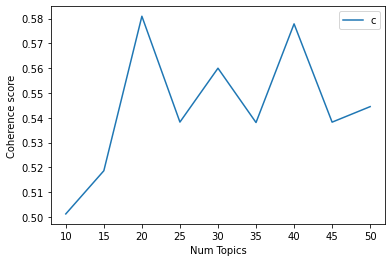

In [21]:
max_topics=50; start=10; step=5;
x = range(start, max_topics + 1, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [22]:
%%time
evaluate_coherence(df_train['tokens'], lda_model, corpus, dictionary)


Perplexity:  -12.718371771377434

Coherence Score:  0.4836898906020137
CPU times: user 4min 19s, sys: 3.6 s, total: 4min 22s
Wall time: 7min 55s


In [14]:
vis_data = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis_data)

In [27]:
def save_topic_keywords(lda_model, n_words):
    """
    Save topic with its keywords distribution as json
    """
    topic_keywords = lda_model.show_topics(num_topics=-1, num_words=n_words, formatted=False)
    df_topics = pd.DataFrame(topic_keywords, columns=['topic_id', 'keywords'])
    df_topics.to_json('data/topics.json', orient='records')
    
    return df_topics

def save_doc_topics(df, lda_model, dictionary):
    """
    Save topic with its topics distribution as json
    """
    corpus = create_corpus(dictionary, df['tokenized'])
    doc_topic_dist = np.array([[tup[1] for tup in lst] for lst in lda_model[corpus]])
    df_doc_topics = pd.DataFrame(doc_topic_dist, columns=['topic_' + str(x) for x in range(N_TOPICS)])
    df_doc_topics.insert(loc=0, column='uuid', value=df['id'])
    # save this to the models
    df_doc_topics.to_csv('data/doc_topics.csv', index=False)
    
    return df_doc_topics

/home/me/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
